# CCLM2 Nature Futures
-----------------
Produces Figs. 3-4, and parts of Figs. 2,5   
Also produces supplementary figures and tables

In [1]:
import warnings
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.lines import Line2D
import cartopy.crs as ccrs
import cartopy.feature as cf
import mplotutils as mpu # helper functions for cartopy and matplotlib

In [2]:
%load_ext autoreload
%autoreload 2

# Custom settings and functions
from settings import *
from plotting import *
from func_calc import *
from func_stats import *
from func_plots import *

# Mute warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Plotting settings
set_plot_param()
%config InlineBackend.print_figure_kwargs = {'bbox_inches': None, 'facecolor': '1'} # display figues as exported to PDF without 'tight'

# Settings

In [3]:
# Save to
os.makedirs('Figures/surfdata', exist_ok=True)
os.makedirs('Figures/climate/', exist_ok=True)
os.makedirs('Figures/drivers/', exist_ok=True)

In [4]:
# Area for weighted mean
surf_ssp1 = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_ssp1/surf.nc')
area = surf_ssp1.AREA

# Mask of potentially modified grid cells, based on EUNIS habitat mapping area (EU+)
eunis = xr.open_dataarray(dpath_proc + 'eunis_mask_repr.nc')

# Region mask
mask_2D = xr.open_dataarray(dpath_proc + 'regionmask_2D_Dou.nc')
mask_3D = xr.open_dataarray(dpath_proc + 'regionmask_3D_Dou.nc')

# Combine subregins and EU+ into one mask
eunis_mask = xr.where(eunis==1, True, False).rename('EU+') # convert to a boolean mask
eunis_mask = eunis_mask.expand_dims('region').assign_coords(region=['EU+']) # add region dimension
mask_3D_eu = xr.concat([eunis_mask, mask_3D], dim='region') # combine to joint mask

# Subregions (insets Figs. 2 and 5)

In [5]:
regions = list(mask_3D.region.values) # 'North', 'West', 'East', 'South'
colordict = {'North': 'lightblue', 'West': '#beaed4', 'East': '#7fc97f',  'South': '#e49635'} # 'Northern': 'darkslategrey'

# Reverse order for plotting
regions.reverse()
colordict_ordered = {}
for key in regions:
    colordict_ordered[key] = colordict[key]
regions_ordered = xr_replace(mask_2D, [0,1,2,3], [3,2,1,0])

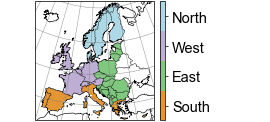

In [6]:
# Plot inset for Fig. 2
with plt.rc_context({'axes.linewidth': 0.35, 'grid.linewidth': 0.35, 'ytick.major.width': 0.35, 'ytick.major.size': 1.5, 'ytick.minor.size': 0}):
    fig, ax = plt.subplots(figsize=(1.8,0.82), subplot_kw=dict(projection=map_proj, facecolor="white"))
    fig.subplots_adjust(hspace=0, wspace=0, left=0, right=0.7, bottom=0.013, top=0.98) # make space for labels and cbars; ignored if constrained_layout=True; left=0.005 without labels
    ax.coastlines(resolution='50m', linewidth=0.3)
    ax.add_feature(cf.BORDERS, linewidth=0.2)
    ax.set_extent([lonmin, lonmax, latmin, latmax], crs=data_proj)
    ax.gridlines(draw_labels=False, linewidth=0.2, color="gray", xlocs=range(-180, 180, 10), ylocs=range(-90, 90, 10))
    h = regions_ordered.plot(ax=ax, transform=ccrs.PlateCarree(), label="region", add_colorbar=False, cmap=colors.ListedColormap(list(colordict_ordered.values())), vmin=-0.5, vmax=2.5, levels=np.arange(-0.5, len(regions), 1))
    cbar = mpu.colorbar(h, ax, orientation='vertical', size=0.04, extend='neither', label='', ticks=np.arange(0, len(regions), 1))
    cbar.set_ticklabels(regions)

    #plt.savefig('Figures/Fig2_regions_Dou.pdf')
    plt.savefig('Figures/Fig2_regions_Dou.png')
plt.show()

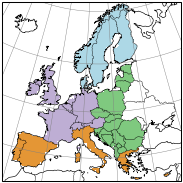

In [7]:
# Plot inset for Fig. 5
fig, ax = plt.subplots(figsize=(3.1/2.54,3.1/2.54), subplot_kw=dict(projection=map_proj, facecolor="white"))
fig.subplots_adjust(hspace=0, wspace=0, left=0, right=1, bottom=0.01, top=0.99) # make space for labels and cbars; ignored if constrained_layout=True; left=0.005 without labels
ax.coastlines(resolution='50m', linewidth=0.3)
ax.add_feature(cf.BORDERS, linewidth=0.2)
ax.set_extent([lonmin, lonmax, latmin, latmax], crs=data_proj)
ax.gridlines(draw_labels=False, linewidth=0.2, color="gray", xlocs=range(-180, 180, 10), ylocs=range(-90, 90, 10))
h = regions_ordered.plot(ax=ax, transform=ccrs.PlateCarree(), label="region", add_colorbar=False, cmap=colors.ListedColormap(list(colordict_ordered.values())), vmin=-0.5, vmax=2.5, levels=np.arange(-0.5, len(regions), 1))
#plt.savefig('Figures/Fig5_regions_Dou.pdf')
plt.savefig('Figures/Fig5_regions_Dou.png')
plt.show()

# Land cover

In [8]:
# Surface datasets
file = 'surf.nc'
surf_orig = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_hist/' + file)
surf_2015 = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_2015/' + file)
surf_ssp1 = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_ssp1/' + file)
surf_nfn = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_nfn/' + file)
surf_nfs = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_nfs/' + file)
surf_nac = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_nac/' + file)

In [9]:
area.fillna(0).count().item() # 426,000 cells in analysed domain
area.count().item() # 169,763 cells over land
eunis.count().item() # 65,849 over land within EUNIS = EU+ (eunis is more generous along coastlines)
mask_2D.count().item() # 62,925 within subregions within eunis

62925

In [10]:
# Area in km2
area.where(eunis==1).sum().item() / 10**6 # 10^6 km2 = 100 Mha

4.879914810193313

## Percent PFT changes

In [11]:
# Prepare dataset
vars = ['pct_change']
ds = xr.concat([surf_nfn[vars],
                surf_nfs[vars],
                surf_nac[vars]], dim='case').assign_coords({'case': ('case', ['nfn-ssp1','nfs-ssp1','nac-ssp1'])})
ds = ds.where(eunis==1)

### EU+ and regional summary (Supp. Table 1)

In [12]:
# Number and percentage of grid cells that change (not weighted by area!)
change_no = ds.where(ds>0).count(dim=['lat','lon'])
total_no = ds.count(dim=['lat','lon'])
pd.concat([change_no.to_pandas(), (100*change_no/total_no).to_pandas()], axis=1)

,pct_change,pct_change
case,,
nfn-ssp1,57177,86.830476
nfs-ssp1,57417,87.194946
nac-ssp1,64078,97.310513


In [13]:
# Percentage area undergoing a net transition
ds.weighted(mask_3D_eu*area.fillna(0)).mean(['lat','lon'])['pct_change'].to_pandas().T.round(1)

case,nfn-ssp1,nfs-ssp1,nac-ssp1
region,,,
EU+,10.0,10.5,21.0
North,5.1,5.1,8.5
West,13.9,14.3,25.0
East,14.4,14.7,25.6
South,4.2,5.5,22.7


In [14]:
# Area (km2, then Mha) undergoing a net transition
((ds['pct_change']/100*area).weighted(mask_3D_eu).sum(['lat','lon']).to_pandas() /10**4).round(1).T

case,nfn-ssp1,nfs-ssp1,nac-ssp1
region,,,
EU+,48.7,51.1,102.6
North,5.5,5.6,9.2
West,18.6,19.1,33.5
East,18.9,19.3,33.7
South,4.0,5.1,21.3


In [15]:
# All grid cells
df_change = ds.to_dataframe().reset_index().pivot(index=['lat','lon'], columns='case', values='pct_change')
df_change.mean()[['nfn-ssp1','nfs-ssp1','nac-ssp1']] # mean
df_change.median()[['nfn-ssp1','nfs-ssp1','nac-ssp1']] # median, round up: 5, 6, 16

case
nfn-ssp1     4.964359
nfs-ssp1     5.263158
nac-ssp1    15.551294
dtype: float64

In [16]:
# Number of grid cells that change completely
ds.where(ds==100).count(['lat','lon']).to_pandas()

,pct_change
case,
nfn-ssp1,21
nfs-ssp1,32
nac-ssp1,22


### Maps (Supp. Fig. 1)

In [17]:
col_headers = ['NfN−SSP1', 'NfS−SSP1', 'NaC−SSP1']
row_headers = ['PFT change (%)']

fig, axes = plt.subplots(1,3, figsize=(double_width,2), subplot_kw=dict(projection=map_proj, facecolor="white"))
format_axes(axes.flatten())
add_headers(fig, col_headers=col_headers, row_headers=row_headers, row_pad=1, font='Arial', fontsize=7) # has to be before mpu.colorbar because it creates additional axes    
fig.subplots_adjust(hspace=0.05, wspace=0.05, left=0.03, right=0.935, bottom=0.03, top=0.9) # make space for labels and cbars; ignored if constrained_layout=True; left=0.005 without labels

var = 'pct_change'
vmin=0; vmax=50; levels=np.arange(vmin, vmax+1, 5); extend='max' # levels for discrete colorbar
opt = dict(transform=data_proj, vmin=vmin, vmax=vmax, levels=levels, extend=extend, add_colorbar=False, cmap='PuBuGn')
for col,case in enumerate(ds.case.values):
    h = ds.sel(case=case)[var].plot(ax=axes[col], **opt);
    axes[col].set_title('')
cbar = mpu.colorbar(h, axes[2], orientation='vertical', size=0.04, extend=extend, label='', pad=0.05)

mpu.set_map_layout(axes, width=14) # width in cm
fig.canvas.draw() # needed to ensure that mpu colorbar keeps its size
#plt.savefig('Figures/surfdata/SM-Fig1_pct_change.pdf')
plt.savefig('Figures/surfdata/SM-Fig1_pct_change.png')

## PFT fractions

In [18]:
# Prepare dataset
vars = ['pct_pft']
ds = xr.concat([surf_orig[vars],
                surf_2015[vars],
                surf_ssp1[vars],
                surf_nfn[vars],
                surf_nfs[vars],
                surf_nac[vars]], dim='case').assign_coords({'case': ('case', ['CLM5','Recent','ssp1','nfn','nfs','nac'])})
ds = ds.where(eunis==1)

### EU+ summary

In [19]:
def summarize_pft(ds, scenario):
    PFT_data = pd.DataFrame({'Name': ["Bare", "NET temperate", "NET boreal", "NDT boreal", "BET tropical", "BET temperate", \
                                      "BDT tropical", "BDT temperate", "BDT boreal", "BES temperate", "BDS temperate", "BDS boreal", \
                                      "C3 arctic grass", "C3 grass", "C4 grass", "C3 crop Uirr", "C3 crop Irr"], \
                             'Main': ["Bare", "NET", "NET", "NDT", "BET", "BET", "BDT", "BDT", "BDT", "BES", "BDS", "BDS", \
                                      "C3 grass", "C3 grass", "C4 grass", "Crop rain", "Crop irr"], \
                             'Type': ["Bare", "Tree NL", "Tree NL", "Tree NL", "Tree BL", "Tree BL", "Tree BL", "Tree BL", "Tree BL", "Shrub", "Shrub", "Shrub", \
                                      "Grass", "Grass", "Grass", "Crop", "Crop"], \
                             'Variant': ["Bare", "Temperate", "Boreal", "Boreal", "Tropical", "Temperate", "Tropical", "Temperate", "Boreal", \
                                         "Evergreen temperate", "Deciduous temperate", "Deciduous boreal", "C3 arctic", "C3", "C4", "C3 Uirr", "C3 Irr"], \
                             'AreaEU_'+scenario: np.zeros(17), \
                             'AreaEU%_'+scenario: np.zeros(17)})
    # Calculate area in EU+ and fill the table
    area_tot = area.where(eunis==1).sum().item() /10**6 # in 10^6 km2
    area_pft = (area*ds.pct_pft/100).where(eunis==1) /10**6 # in 10^6 km2
    PFT_data['AreaEU_'+scenario] = area_pft.sum(dim=("lat","lon"))
    PFT_data['AreaEU%_'+scenario] = (100*PFT_data['AreaEU_'+scenario]/area_tot).round(2) # % of land
    
    return PFT_data

In [20]:
# Prepare dataset
orig = summarize_pft(surf_orig, 'CLM5')
recent = summarize_pft(surf_2015, 'recent')
ssp1 = summarize_pft(surf_ssp1, 'ssp1')
nfn = summarize_pft(surf_nfn, 'nfn')
nfs = summarize_pft(surf_nfs, 'nfs')
nac = summarize_pft(surf_nac, 'nac')

df_eu = orig.join([recent['AreaEU%_recent'],ssp1['AreaEU%_ssp1'],nfn['AreaEU%_nfn'],nfs['AreaEU%_nfs'],nac['AreaEU%_nac']])

In [21]:
# Table (absolute values)
df_table = df_eu.groupby('Type')[['AreaEU%_CLM5','AreaEU%_recent','AreaEU%_ssp1', 'AreaEU%_nfn', 'AreaEU%_nfs', 'AreaEU%_nac']].sum()
df_table.columns = ['CLM5', 'Recent', 'SSP1', 'NFN', 'NFS', 'NAC']
df_table = df_table.reindex(['Tree NL', 'Tree BL', 'Shrub', 'Grass', 'Crop', 'Bare'])
#df_table = df_table.rename(index={'Tree NL': 'Tree needleleaf', 'Tree BL':'Tree broadleaf'})
#df_table.to_excel('Tables/PFT-cover-percent-EU+.xlsx')
df_table

,CLM5,Recent,SSP1,NFN,NFS,NAC
Type,,,,,,
Tree NL,20.43,7.75,8.52,7.77,7.71,7.96
Tree BL,8.31,10.47,13.36,11.36,11.07,11.65
Shrub,2.21,4.39,5.56,5.28,4.91,5.78
Grass,39.10,29.57,26.54,28.05,27.59,39.28
Crop,24.22,38.06,36.26,37.48,38.77,24.22
Bare,0.83,4.87,4.88,5.17,5.06,6.21


In [22]:
# Barplot (changes SSP1-recent and scenario-SSP1)
# Format as inset
colordict = {'Tree NL': 'darkslategrey', 'Tree BL': 'green', 'Shrub': 'olive', 'Grass': 'khaki', 'Crop': '#e49635', 'Bare': 'lightgrey'}
data = df_table[['NFN', 'NFS', 'NAC']].sub(df_table['SSP1'], axis=0).T # scenario-SSP1
data = data[list(colordict.keys())] # sort
data_ssp1 = df_table[['SSP1']].sub(df_table['Recent'], axis=0).T # SSP1-recent
data_ssp1 = data_ssp1[list(colordict.keys())] # sort

fig, axes = plt.subplots(1,2, figsize=(3.3,1.3), width_ratios=(1,3), sharey=True, constrained_layout=True) # 3.54 is single width
data_ssp1.plot(ax=axes[0], kind='bar', width=0.7, color=colordict.values(), rot=0, zorder=2, legend=None);
data.plot(ax=axes[1], kind='bar', width=0.7, color=colordict.values(), rot=0, zorder=2);
legend = axes[1].legend(['Tree needleleaf', 'Tree broadleaf', 'Shrub', 'Grass', 'Crop', 'Bare'], frameon=False, loc='center left', bbox_to_anchor=(1, 0.5))
axes[0].set_ylim(-13.5, 13.5)
axes[0].set_ylabel('Area (%)', labelpad=0)
axes[0].set_yticks(np.arange(-10, 15, 5))
for ax in axes.flatten():
    ax.set_xlabel('')
    #ax.set_xticklabels(['NFN−SSP1', 'NFS−SSP1', 'NAC−SSP1'])
    ax.grid(which='major', axis='y', color='grey', linestyle=(0, (5, 10)), linewidth=0.3, zorder=0);
    ax.axhline(0, color='black', linewidth=0.5, zorder=2);
#ax.set_title('Changes in land cover composition relative to SSP1');
#plt.savefig('Figures/surfdata/pft_change_eu.pdf')
#plt.savefig('Figures/surfdata/pft_change_eu.png')

### Regional summary (insets Fig. 5)

In [23]:
# Here, split crop rainfed and irrigated
def summarize_pft_reg(ds, scenario, region=None):
    PFT_data = pd.DataFrame({'Name': ["Bare", "NET temperate", "NET boreal", "NDT boreal", "BET tropical", "BET temperate", \
                                      "BDT tropical", "BDT temperate", "BDT boreal", "BES temperate", "BDS temperate", "BDS boreal", \
                                      "C3 arctic grass", "C3 grass", "C4 grass", "C3 crop Uirr", "C3 crop Irr"], \
                             'Main': ["Bare", "NET", "NET", "NDT", "BET", "BET", "BDT", "BDT", "BDT", "BES", "BDS", "BDS", \
                                      "C3 grass", "C3 grass", "C4 grass", "Crop rain", "Crop irr"], \
                             'Type': ["Bare", "Tree NL", "Tree NL", "Tree NL", "Tree BL", "Tree BL", "Tree BL", "Tree BL", "Tree BL", "Shrub", "Shrub", "Shrub", \
                                      "Grass", "Grass", "Grass", "Crop R", "Crop I"], \
                             'Variant': ["Bare", "Temperate", "Boreal", "Boreal", "Tropical", "Temperate", "Tropical", "Temperate", "Boreal", \
                                         "Evergreen temperate", "Deciduous temperate", "Deciduous boreal", "C3 arctic", "C3", "C4", "C3 Uirr", "C3 Irr"]})
    PFT_data['lsmpft'] = np.arange(0,17)
    area_tot = area.where(eunis==1).weighted(mask_3D_eu).sum(dim=['lat','lon']) /10**6
    area_pft = (area*ds.pct_pft/100).where(eunis==1).weighted(mask_3D_eu).sum(dim=['lat','lon']) /10**6 # in 10^6 km2
    df = area_pft.to_dataframe(name='AreaEU_'+scenario).drop(columns='pftname')
    df['AreaEU%_'+scenario] = (100*area_pft/area_tot).to_pandas().stack() # % of land
    df = df.reset_index()
    PFT_data = df.merge(PFT_data, on='lsmpft').drop(columns='lsmpft')
    if region is not None:
        PFT_data = PFT_data.loc[PFT_data.region==region]
    
    return PFT_data

EU+


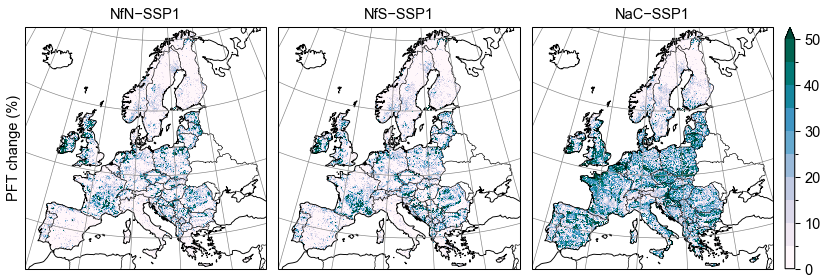

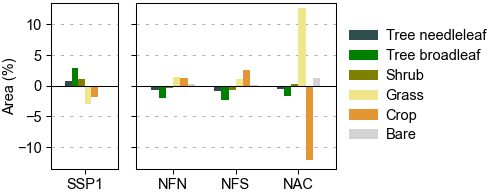

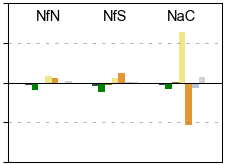

North


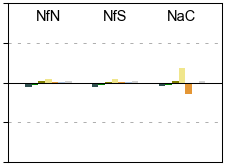

West


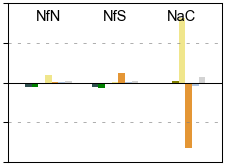

East


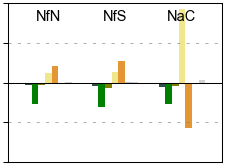

South


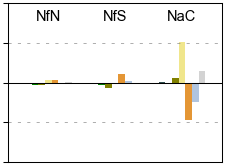

In [24]:
# Barplot changes relative to SSP1, by region, for Fig5
colordict = {'Tree NL': 'darkslategrey', 'Tree BL': 'green', 'Shrub': 'olive', 'Grass': 'khaki', 'Crop R': '#e49635', 'Crop I': 'lightsteelblue', 'Bare': 'lightgrey'}
for region in ['EU+', 'North', 'West', 'East', 'South']:
    # Prepare dataset   
    recent = summarize_pft_reg(surf_2015, 'recent', region)
    ssp1 = summarize_pft_reg(surf_ssp1, 'ssp1', region)
    nfn = summarize_pft_reg(surf_nfn, 'nfn', region)
    nfs = summarize_pft_reg(surf_nfs, 'nfs', region)
    nac = summarize_pft_reg(surf_nac, 'nac', region)
    df = recent.join([ssp1['AreaEU%_ssp1'],nfn['AreaEU%_nfn'],nfs['AreaEU%_nfs'],nac['AreaEU%_nac']])
    
    # Table (absolute values)
    df_table = df.groupby('Type')[['AreaEU%_recent','AreaEU%_ssp1', 'AreaEU%_nfn', 'AreaEU%_nfs', 'AreaEU%_nac']].sum()
    df_table.columns = ['Recent', 'SSP1', 'NfN', 'NfS', 'NaC'] 
    data = df_table[['NfN', 'NfS', 'NaC']].sub(df_table['SSP1'], axis=0).T # scenario-SSP1
    data = data[list(colordict.keys())] # sort

    # Plot
    print(region)
    fig, ax = plt.subplots(figsize=(1.5,1.1), constrained_layout=True) # 3.54 is single width
    data.plot(ax=ax, kind='bar', width=0.7, color=colordict.values(), rot=0, legend=False);
    #legend = ax.legend(['Tree needleleaf', 'Tree broadleaf', 'Shrub', 'Grass', 'Crop', 'Bare'], frameon=False, loc='center left', bbox_to_anchor=(1, 0.5))
    ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
    ax.tick_params(axis='x', direction='in', pad=-10, zorder=5)
    ax.xaxis.set_ticks_position('none')
    ax.set_ylim(-20, 20)
    ax.set_yticklabels([])
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.grid(which='major', axis='y', color='grey', linestyle=(0, (5, 10)), linewidth=0.3, zorder=0);
    ax.axhline(0, color='black', linewidth=0.5, zorder=2);
    plt.savefig(f'Figures/surfdata/Fig5_pft_change_reg_{region}.png')
    plt.show()

Legend


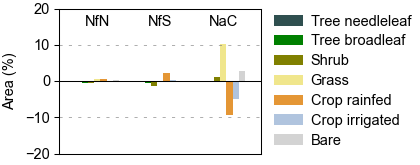

In [25]:
print('Legend')
fig, ax = plt.subplots(figsize=(2.8,1.1), constrained_layout=True) # 3.54 is single width
data.plot(ax=ax, kind='bar', width=0.7, color=colordict.values(), rot=0, legend=False);
legend = ax.legend(['Tree needleleaf', 'Tree broadleaf', 'Shrub', 'Grass', 'Crop rainfed', 'Crop irrigated', 'Bare'], frameon=False, loc='center left', bbox_to_anchor=(1, 0.5))
ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
ax.tick_params(axis='x', direction='in', pad=-10, zorder=5)
ax.xaxis.set_ticks_position('none')
ax.set_ylim(-20, 20)
ax.set_ylabel('Area (%)')
ax.set_xlabel('')
ax.grid(which='major', axis='y', color='grey', linestyle=(0, (5, 10)), linewidth=0.3, zorder=0);
ax.axhline(0, color='black', linewidth=0.5, zorder=2);
plt.savefig(f'Figures/surfdata/Fig5_pft_change_reg_legend.png')
plt.show()

### Maps (Supp. Fig. 2)

In [26]:
# Prepare dataset
vars = ['PCT_TREE_NL','PCT_TREE_BL','PCT_GRASS','PCT_CROP'] # bare and shrub not shown
ds = xr.concat([surf_ssp1[vars],
                diff_masked(surf_nfn[vars], surf_ssp1[vars]),
                diff_masked(surf_nfs[vars], surf_ssp1[vars]),
                diff_masked(surf_nac[vars], surf_ssp1[vars])], dim='case').assign_coords({'case': ('case', ['ssp1','nfn-ssp1','nfs-ssp1','nac-ssp1'])})
surf_frac = ds.copy(deep=True) # save for correlation

In [27]:
col_headers = ['SSP1', 'NfN−SSP1', 'NfS−SSP1', 'NaC−SSP1']
row_headers = ['Tree needleleaf (%)', 'Tree broadleaf (%)', 'Grass (%)', 'Crop (%)']

fig, axes = plt.subplots(4,4, figsize=(double_width,7), subplot_kw=dict(projection=map_proj, facecolor="white"))
format_axes(axes.flatten())
add_headers(fig, col_headers=col_headers, row_headers=row_headers, row_pad=1, font='Arial', fontsize=7) # has to be before mpu.colorbar because it creates additional axes    
fig.subplots_adjust(hspace=0.05, wspace=0.05, left=0.025, right=0.993, bottom=0.045, top=0.975) # make space for labels and cbars; ignored if constrained_layout=True; left=0.005 without labels

# Col 1: plot SSP1 absolute
vmin=0; vmax=100; levels=np.arange(vmin, vmax+1, 10) # levels for discrete colorbar
opt = dict(transform=data_proj, vmin=vmin, vmax=vmax, levels=levels, extend='neither', add_colorbar=False, cmap='PuBuGn')
for var,ax in zip(vars,axes[:,0]):
    h = ds.sel(case='ssp1')[var].plot(ax=ax, **opt);
    ax.set_title('')
cbar = mpu.colorbar(h, ax, orientation='horizontal', size=0.04, extend='neither', label='', pad=0.05) # size: width of the colorbar as fraction of the axes width (vertical) or height (horizontal)

# Cols 2-4: plot scenarios releative
vmin=-60; vmax=60; levels=np.arange(vmin, vmax+1, 10) # levels for discrete colorbar
opt = dict(transform=data_proj, vmin=vmin, vmax=vmax, levels=levels, extend='both', add_colorbar=False, cmap='PiYG')
for col,case in enumerate(ds.case.values[1:], start=1):
    for var,ax in zip(vars,axes[:,col]):
        h = ds.sel(case=case)[var].plot(ax=ax, **opt);
        ax.set_title('')
cbar = mpu.colorbar(h, axes[3,1], axes[3,3], shrink=0.5, orientation='horizontal', size=0.04, extend='both', label='', pad=0.05)

mpu.set_map_layout(axes, width=18) # width in cm
fig.canvas.draw() # needed to ensure that mpu colorbar keeps its size
#plt.savefig('Figures/surfdata/SM-Fig2_pft_fractions.pdf')
plt.savefig('Figures/surfdata/SM-Fig2_pft_fractions.png')

## Dominant cover and transitions (Fig. 3b)

In [28]:
# Dominant transitions based on max loss and gain
def dom_nff(surf_nff):
    dom = (surf_nff[vars]-surf_ssp1[vars]).to_array(dim='lc', name=None).assign_coords(lc=('lc', lctypes_num)) # add as coordinate to existing dimension
    dom = dom.where(dom.min('lc')<=-5).where(dom.max('lc')>=5) # mask min 5% LC change
    idxmin = dom.idxmin(dim='lc', skipna=True, fill_value=0).rename('Min').astype('str')
    idxmax = dom.idxmax(dim='lc', skipna=True, fill_value=0).rename('Max').astype('str')
    dom = idxmin.str.cat(idxmax).astype('int') # combine strings, convert back to numerical
    dom = dom.where(veg_mask) # mask cells that are zero for all PFTs (otherwise plotted as first category)
    dom = dom.where(eunis==1) # mask potentially modified cells
    dom = dom.where(dom>11) # remove 1->1 transition
    return dom

In [29]:
# Prepare dataset
vars = ['PCT_TREE_NL','PCT_TREE_BL','PCT_SHRUB','PCT_GRASS','PCT_CROP','PCT_BARE']
lctypes = ['TreeNL', 'TreeBL', 'Shrub', 'Grass', 'Crop', 'Bare']
lctypes_num = [1, 2, 3, 4, 5, 6]
veg_mask = (surf_ssp1.PCT_NATVEG+surf_ssp1.PCT_CROP)>0

# SSP1 dominant lc
dom_ssp1 = surf_ssp1[vars].to_array(dim='lc', name=None).assign_coords(lc=('lc', lctypes_num)) # add as coordinate to existing dimension
dom_ssp1 = dom_ssp1.idxmax(dim='lc', skipna=True, fill_value=np.nan)
dom_ssp1 = dom_ssp1.where(veg_mask) # mask cells that are zero for all PFTs (otherwise plotted as first category)

# Dominant transitions
dom_nfn = dom_nff(surf_nfn)
dom_nfs = dom_nff(surf_nfs)
dom_nac = dom_nff(surf_nac)
ds = xr.concat([dom_nfn, dom_nfs, dom_nac], dim='case').assign_coords({'case': ('case', ['nfn-ssp1','nfs-ssp1','nac-ssp1'])})
#ds.to_netcdf(dpath_proc + 'dominant_transitions.nc')

# Count cells per transition
transitions = xr.concat([dom_nfn.groupby(dom_nfn).count(),
                         dom_nfs.groupby(dom_nfs).count(),
                         dom_nac.groupby(dom_nac).count()], dim='case').assign_coords({'case': ('case', ['nfn-ssp1','nfs-ssp1','nac-ssp1'])}).to_dataframe('count')
transitions = transitions.reset_index().pivot(columns='case', index='group')
transitions.columns = ['nac-ssp1','nfn-ssp1','nfs-ssp1'] # sorted alphabetically
transitions = transitions[['nfn-ssp1','nfs-ssp1','nac-ssp1']]
transitions['importance_total'] = transitions.sum(axis=1)/(transitions.sum().sum()) *100
transitions = transitions.sort_values('importance_total', ascending=False)
transitions['importance_indivmax'] = transitions.max(axis=1)/([transitions.loc[:,transitions.loc[row].idxmax()].sum() for row in transitions.index]) *100
top8 = transitions.iloc[0:8].index.values
transitions.head(8)

,nfn-ssp1,nfs-ssp1,nac-ssp1,importance_total,importance_indivmax
group,,,,,
54.0,5650,4805,25604,41.121463,61.412261
25.0,5017,5532,3854,16.425093,23.796619
45.0,4455,5103,2126,13.324362,21.951220
24.0,1783,1656,3324,7.712484,7.972753
15.0,1069,1222,1046,3.805494,5.256592
14.0,1048,908,1036,3.412059,4.606593
56.0,558,574,1489,2.988972,3.571429
52.0,892,837,533,2.579571,3.920879


In [30]:
# Most common transitions across scenarios
# 54 Crop to grass - NFN, NAC
# 25 TreeBL to crop - NFS
# 45 Grass to crop
# 24 TreeBL to grass
# 15 TreeNL to crop
# 14 TreeNL to grass
# 56 Crop to bare
# 52 Crop to treeBL

# Reindex to 1-8 for plotting. Sorted by what it transitions to
to_replace = [52, 14, 24, 54, 15, 25, 45, 56]
replace_with = [1, 2, 3, 4, 5, 6, 7, 8]
ds = ds.where(ds.isin(top8))
ds = xr_replace(ds, to_replace, replace_with)

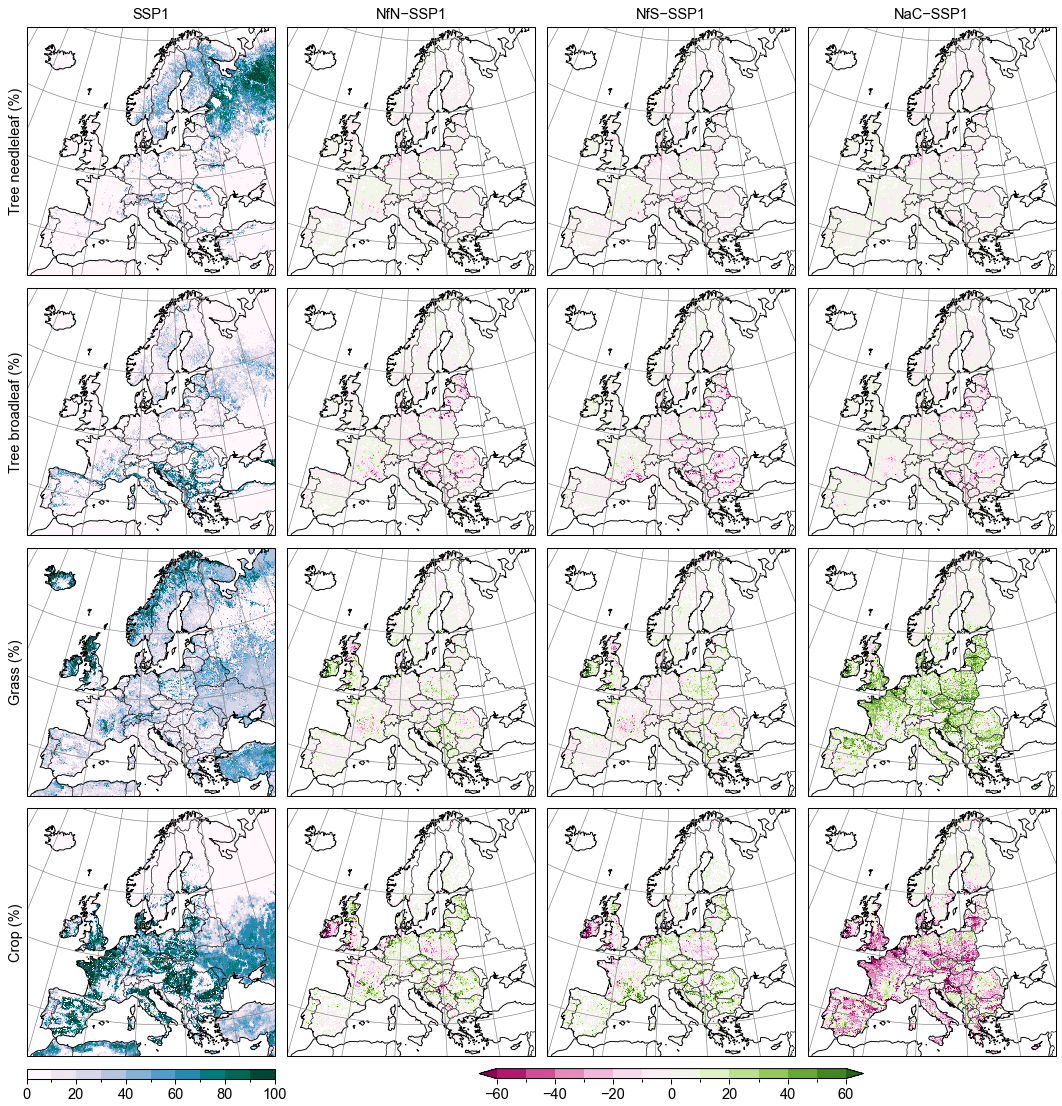

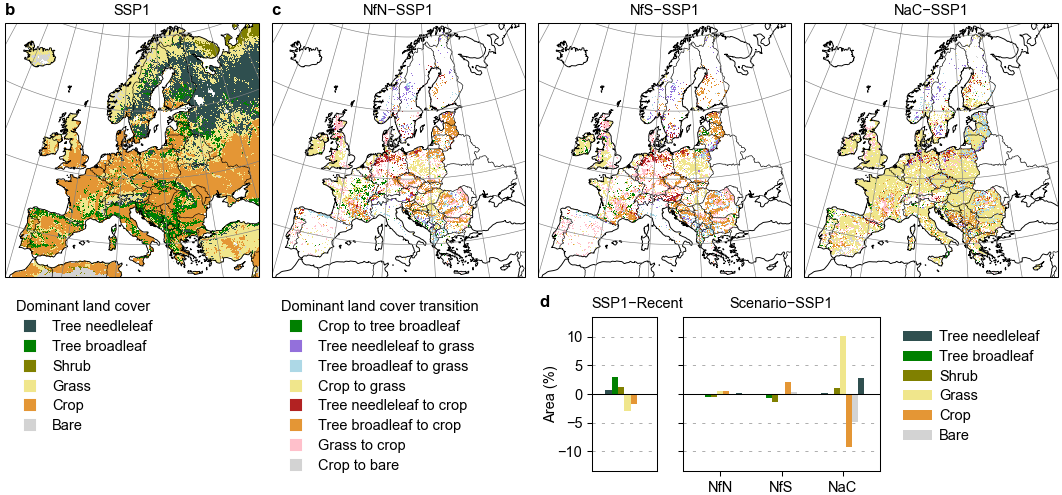

In [31]:
fig = plt.figure(figsize=(double_width,3.3), constrained_layout=False)
subfigs = fig.subfigures(2,1, height_ratios=(3,2), hspace=0, wspace=0)
subfigs[0].subplots_adjust(hspace=0.05, wspace=0.05, left=0.005, right=0.995, bottom=0.01, top=0.98)
subfigs[1].subplots_adjust(hspace=0.05, wspace=0.05, left=0.005, right=0.995, bottom=0.01, top=0.98)

# Top (maps)
axes1 = subfigs[0].subplots(1,4, subplot_kw=dict(projection=map_proj, facecolor="white"))
format_axes(axes1.flatten())
col_headers = ['SSP1', 'NfN−SSP1', 'NfS−SSP1', 'NaC−SSP1']
add_headers(fig, col_headers=col_headers, row_headers=None, font='Arial', fontsize=7) # has to be before mpu.colorbar because it creates additional axes    

# Bottom
subfigsnest = subfigs[1].subfigures(1,2, wspace=0.03)
# Left: dummy axes to place legends
subfigsnest[0].subplots_adjust(top=1)
axes2 = subfigsnest[0].subplots(1,2)
for ax in axes2:
    ax.axis('off')
# Right: barplots
subfigsnest[1].subplots_adjust(hspace=0.05, wspace=0.2, left=0.1, right=0.65, bottom=0.12, top=0.9)

# Dominant transitions
# SSP1 dominant LC
colordict = {'Tree needleleaf': 'darkslategrey', 'Tree broadleaf': 'green', 'Shrub': 'olive', 'Grass': 'khaki', 'Crop': '#e49635', 'Bare': 'lightgrey'}
ax = axes1[0]
h = dom_ssp1.plot(ax=ax, transform=data_proj, add_colorbar=False, vmin=1, vmax=7, levels=7, colors=list(colordict.values())); # vmin=1, vmax=6, np.arange(1, len(lctypes)+2, 1)
custom_points = [Line2D([0], [0], marker="s", linestyle="none", markersize=5, color=color) for color in colordict.values()]
leg = axes2[0].legend(custom_points, colordict.keys(), title="Dominant land cover", frameon=False, loc='upper left', bbox_to_anchor=(0,1.05), ncols=1)
leg._legend_box.align = 'left'

# NFF dominant transitions
colordict = {'Crop to tree broadleaf': 'green',
             'Tree needleleaf to grass': 'mediumpurple',
             'Tree broadleaf to grass': 'lightblue',
             'Crop to grass': 'khaki',
             'Tree needleleaf to crop': 'firebrick',
             'Tree broadleaf to crop': '#e49635', 
             'Grass to crop': 'pink',
             'Crop to bare': 'lightgrey'}
for case,ax in zip(ds.case.values, axes1[1:]):
    h = ds.sel(case=case).plot(ax=ax, transform=data_proj, add_colorbar=False, vmin=1, vmax=9, levels=9, colors=list(colordict.values())); # vmin=1, vmax=6, np.arange(1, len(lctypes)+2, 1)
    ax.set_title('')
custom_points = [Line2D([0], [0], marker="s", linestyle="none", markersize=5, color=color) for color in colordict.values()]
leg = axes2[1].legend(custom_points, colordict.keys(), title="Dominant land cover transition", frameon=False, loc='upper left', bbox_to_anchor=(0,1.05), ncols=1)
leg._legend_box.align = 'left'

# Barplots
colordict = {'Tree needleleaf': 'darkslategrey', 'Tree broadleaf': 'green', 'Shrub': 'olive', 'Grass': 'khaki', 'Crop': '#e49635', 'Bare': 'lightgrey'}
axes3 = subfigsnest[1].subplots(1,2, sharey=True, width_ratios=(1,3))
data_ssp1.plot(ax=axes3[0], kind='bar', width=0.7, color=colordict.values(), rot=0, zorder=2, legend=None);
data.plot(ax=axes3[1], kind='bar', width=0.7, color=colordict.values(), rot=0, zorder=2);
legend = axes3[1].legend(['Tree needleleaf', 'Tree broadleaf', 'Shrub', 'Grass', 'Crop', 'Bare'], frameon=False, loc='upper left', bbox_to_anchor=(1.05,1))
axes3[0].set_ylim(-13.5, 13.5)
axes3[0].set_ylabel('Area (%)', labelpad=0)
axes3[0].set_yticks(np.arange(-10, 15, 5))
for ax in axes3:
    ax.set_xlabel('')
    ax.grid(which='major', axis='y', color='grey', linestyle=(0, (5, 10)), linewidth=0.3, zorder=0);
    ax.axhline(0, color='black', linewidth=0.5, zorder=2);
#axes3[0].set_xticklabels(['SSP1−Recent'])
axes3[0].set_xticks([])
axes3[1].set_xticklabels(['NfN', 'NfS', 'NaC'])
axes3[0].set_title('SSP1−Recent', loc='left')
axes3[1].set_title('Scenario−SSP1')

# Panel labels
axes1[0].annotate('b', xy=(0,1), xytext=(0,4), xycoords='axes fraction', textcoords="offset points", fontsize=8, font='Arial', fontweight='bold', ha='left', va='baseline')
axes1[1].annotate('c', xy=(0,1), xytext=(0,4), xycoords='axes fraction', textcoords="offset points", fontsize=8, font='Arial', fontweight='bold', ha='left', va='baseline')
axes3[0].annotate('d', xy=(0,0.95), xytext=(0,0), xycoords='subfigure fraction', textcoords="offset points", fontsize=8, font='Arial', fontweight='bold', ha='left', va='baseline')

#plt.savefig('Figures/surfdata/Fig3b.pdf')
plt.savefig('Figures/surfdata/Fig3b.png')
plt.show()

## Hatplot land systems, EUNIS, PFTs (Fig. 3a)

In [32]:
df_dou = xr.open_dataset(dpath_luc + 'Dou-et-al_scenarios_4reg.nc').to_dataframe()
df_eunis = xr.open_dataset(dpath_luc + 'EUNIS_scenarios_4reg.nc').to_dataframe() #.reset_index().set_index('region')
df_eunis = df_eunis.rename(columns={'Forests':'Forest', 'Grasslands':'Grass', 'Shrublands':'Scrub', 'Bare and sparse': 'Bare', 'Costal': 'Coastal'})
df_pft = xr.open_dataset(dpath_luc + 'PFT_scenarios_4reg.nc').to_dataframe() #.reset_index().set_index('region')
df_pft = df_pft.rename(columns={'Tree needleleaf': 'Tree NL', 'Tree broadleaf': 'Tree BL'})

# Rescale datasets to exclude water
df_dou = df_dou.drop(columns='Water')
df_dou = df_dou.div(df_dou.sum(axis=1), axis=0)*100
df_dou = df_dou.reset_index().set_index('region')
df_eunis = df_eunis.drop(columns='Water')
df_eunis = df_eunis.div(df_eunis.sum(axis=1), axis=0)*100
df_eunis = df_eunis.reset_index().set_index('region')
df_pft = df_pft.drop(columns=['Wetland','Glacier','Water']) # wetland landunit in CLM does not represent wetlands in ecological sense; glacier is included in water in Dou et al.
df_pft = df_pft.div(df_pft.sum(axis=1), axis=0)*100
df_pft = df_pft.reset_index().set_index('region')

In [33]:
lc_dou = ['Forest', 'Shrub', 'Grass', 'Crop', 'Mosaic', 'Bare', 'Urban']
lc_eunis = ['Forest', 'Scrub', 'Grass', 'Man-made', 'Coastal', 'Bare', 'Urban'] # 'Wetlands'
lc_pft = ['Tree NL', 'Tree BL', 'Shrub', 'Grass', 'Crop', 'Bare'] # , 'Urban'
regions = ['EU+', 'North', 'West', 'East', 'South']

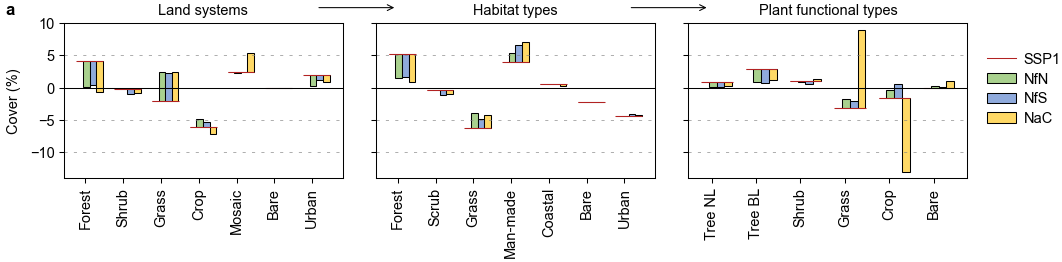

In [34]:
# Plot changes relative to 2015
reg = 'EU+'
fig, axes = plt.subplots(1,3, figsize=(double_width,1.75), sharey=True)
fig.subplots_adjust(wspace=0.12, left=0.06, right=0.91, bottom=0.32, top=0.91)
for ax, title, df, lc_list in zip(axes, ['Land systems', 'Habitat types', 'Plant functional types'], [df_dou, df_eunis, df_pft], [lc_dou, lc_eunis, lc_pft]):
    # Prepare the data
    data = df.loc[reg].reset_index(drop=True).set_index('scenario').T
    data = data[['SSP1', 'NfN', 'NfS', 'NaC']].sub(data['Recent'], axis=0)
    data = data.round(1)
    scenario_list = data.columns.values
    data_list = [data.loc[lc_list, scenario].values for scenario in scenario_list]
    # Plot
    hat_graph(ax=ax, xlabels=lc_list, values=data_list, group_labels=scenario_list, annot=False, colors=['white', '#A9D18E', '#8FAADC', '#FFD966'], baseline_color='firebrick')
    ax.set_title(title)
    ax.grid(which='major', axis='y', color='grey', linestyle=(0, (5, 10)), linewidth=0.3, zorder=0);
    ax.axhline(0, color='black', linewidth=0.5, zorder=2);
    ax.set_ylim(-14,10)
    ax.tick_params(axis='x', labelrotation=90)
handles, labels = axes[2].get_legend_handles_labels()
ref_handle = Line2D([0], [0], color='firebrick', linewidth=0.5) # red line for the reference
axes[2].legend([ref_handle]+handles[1:], labels, frameon=False, loc=(1.05,0.3))
axes[0].set_ylabel('Cover (%)')

# Panel labels and arrows
axes[0].annotate('a', xy=(-0.21,1), xytext=(0,4), xycoords='axes fraction', textcoords="offset points", fontsize=8, font='Arial', fontweight='bold', ha='left', va='baseline')
axes[0].annotate("", xy=(0.9,1.1), xytext=(1.2,1.1), xycoords='axes fraction', arrowprops=dict(arrowstyle='<-', color='black', lw=0.5))
axes[1].annotate("", xy=(0.9,1.1), xytext=(1.2,1.1), xycoords='axes fraction', arrowprops=dict(arrowstyle='<-', color='black', lw=0.5)) 

#plt.savefig('Figures/surfdata/Fig3a.pdf')
plt.savefig('Figures/surfdata/Fig3a.png')
plt.show()

EU+


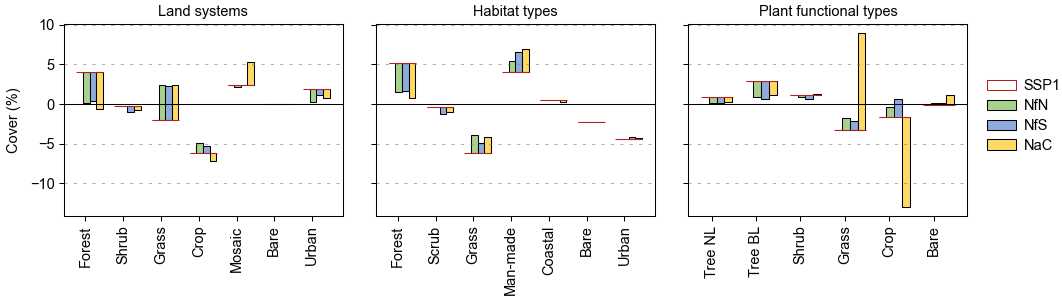

North


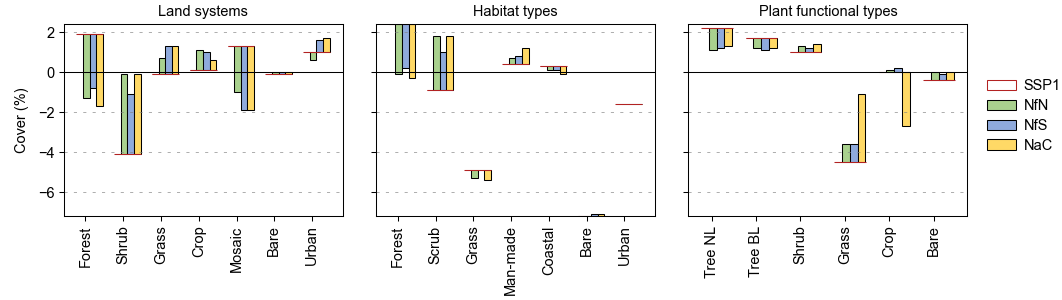

West


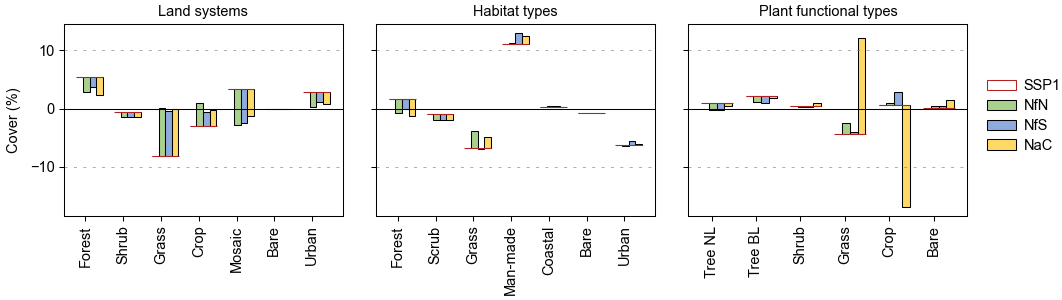

East


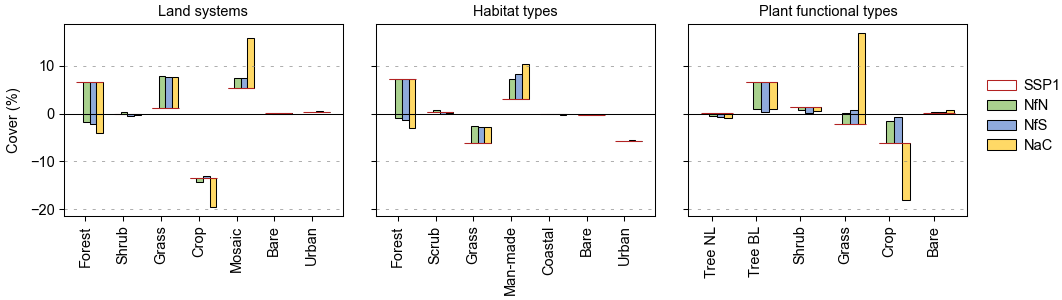

South


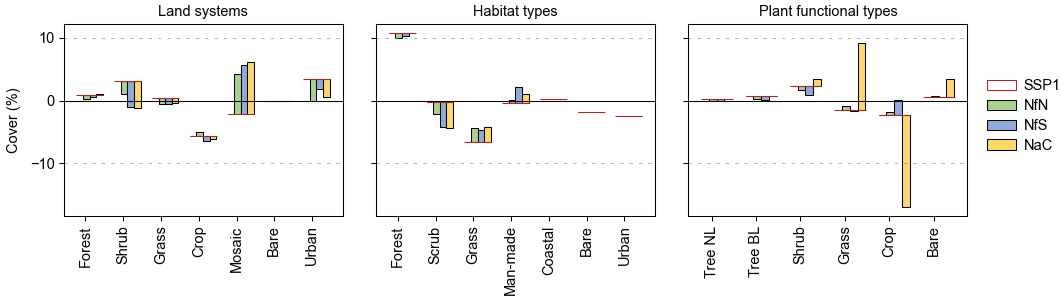

In [35]:
# Plot changes relative to 2015, per subregion
for reg in regions:
    print(reg)
    fig, axes = plt.subplots(1,3, figsize=(double_width,2), sharey=True)
    fig.subplots_adjust(wspace=0.12, left=0.06, right=0.91, bottom=0.28, top=0.92)
    for ax, title, df, lc_list in zip(axes, ['Land systems', 'Habitat types', 'Plant functional types'], [df_dou, df_eunis, df_pft], [lc_dou, lc_eunis, lc_pft]):
        # Prepare the data
        data = df.loc[reg].reset_index(drop=True).set_index('scenario').T
        data = data[['SSP1', 'NfN', 'NfS', 'NaC']].sub(data['Recent'], axis=0)
        data = data.round(1)
        scenario_list = data.columns.values
        data_list = [data.loc[lc_list, scenario].values for scenario in scenario_list]
        # Plot
        hat_graph(ax=ax, xlabels=lc_list, values=data_list, group_labels=scenario_list, annot=False, colors=['white', '#A9D18E', '#8FAADC', '#FFD966'], baseline_color='firebrick')
        ax.set_title(title)
        ax.grid(which='major', axis='y', color='grey', linestyle=(0, (5, 10)), linewidth=0.3, zorder=0);
        ax.axhline(0, color='black', linewidth=0.5, zorder=2);
        #ax.set_ylim(-14,10)
        ax.tick_params(axis='x', labelrotation=90)
    axes[2].legend(frameon=False, loc=(1.05,0.3))
    axes[0].set_ylabel('Cover (%)')
    plt.show()

# Maps LAI (summer), height, irrigation

In [36]:
# Prepare dataset
vars = ['HTOP_summer', 'LAI_summer', 'pct_irrig']
ds = xr.concat([surf_ssp1[vars],
                diff_masked(surf_nfn[vars], surf_ssp1[vars]),
                diff_masked(surf_nfs[vars], surf_ssp1[vars]),
                diff_masked(surf_nac[vars], surf_ssp1[vars])], dim='case').assign_coords({'case': ('case', ['ssp1','nfn-ssp1','nfs-ssp1','nac-ssp1'])})
surf_prop = ds.copy(deep=True) # save for correlation

In [37]:
ds.where(eunis==1).weighted(area.fillna(0)).mean(dim=['lat','lon']).to_dataframe().T

case,ssp1,nfn-ssp1,nfs-ssp1,nac-ssp1
HTOP_summer,4.669007,-0.629801,-0.733350,-0.486779
LAI_summer,1.714658,-0.022807,-0.019470,-0.120555
pct_irrig,3.616552,-0.010484,0.884821,-8.671903


In [38]:
# Plot LAI (summer), height, irrigation
col_headers = ['SSP1', 'NFN−SSP1', 'NFS−SSP1', 'NAC−SSP1']
row_headers = ['Vegetation height (m)', 'LAI summer (JJA) (m² m−²)', 'Irrigated area (%)']

fig = plt.figure(figsize=(double_width,4.7))
subfigs = fig.subfigures(1, 2, width_ratios=[1.2,3], wspace=0)
laxes = subfigs[0].subplots(3,1, subplot_kw=dict(projection=map_proj, facecolor="white"))
raxes = subfigs[1].subplots(3,3, subplot_kw=dict(projection=map_proj, facecolor="white"))
format_axes(laxes.flatten())
format_axes(raxes.flatten())
add_headers(subfigs[0], col_headers=col_headers[0:1], row_headers=row_headers, row_pad=1, font='Arial', fontsize=7) # has to be before mpu.colorbar because it creates additional axes    
add_headers(subfigs[1], col_headers=col_headers[1:], row_headers=None, row_pad=1, font='Arial', fontsize=7) # has to be before mpu.colorbar because it creates additional axes    
lspace=0.09; rspace=0.2
subfigs[0].subplots_adjust(hspace=0.05, wspace=0.05, left=lspace, right=(1-rspace), bottom=0.012, top=0.965)
subfigs[1].subplots_adjust(hspace=0.05, wspace=0.05, left=lspace/3-0.01, right=(1-rspace/3-0.03), bottom=0.012, top=0.965) # make space for labels and cbars; ignored if constrained_layout=True; left=0.005 without labels

# Col 1: plot SSP1 absolute
# HTOP
vmin=0; vmax=20; levels=np.arange(vmin, vmax+1, 2); extend='max'
opt = dict(transform=data_proj, vmin=vmin, vmax=vmax, levels=levels, extend=extend, add_colorbar=False, cmap='RdPu')
h = ds.sel(case='ssp1')['HTOP_summer'].plot(ax=laxes[0], **opt);
cbar = mpu.colorbar(h, laxes[0], orientation='vertical', size=0.04, extend=extend, label='', pad=0.05) # size: width of the colorbar as fraction of the axes width (vertical) or height (horizontal)
# LAI
vmin=0; vmax=3.5; levels=np.arange(vmin, vmax+0.1, 0.5); extend='max'
opt = dict(transform=data_proj, vmin=vmin, vmax=vmax, levels=levels, extend=extend, add_colorbar=False, cmap='PuBuGn')
h = ds.sel(case='ssp1')['LAI_summer'].plot(ax=laxes[1], **opt);
cbar = mpu.colorbar(h, laxes[1], orientation='vertical', size=0.04, extend=extend, label='', pad=0.05) # size: width of the colorbar as fraction of the axes width (vertical) or height (horizontal)
# Irrig
vmin=0; vmax=50; levels=np.arange(vmin, vmax+1, 10); extend='max'
opt = dict(transform=data_proj, vmin=vmin, vmax=vmax, levels=levels, extend=extend, add_colorbar=False, cmap='Blues')
h = masked(ds.sel(case='ssp1')['pct_irrig']).plot(ax=laxes[2], **opt);
cbar = mpu.colorbar(h, laxes[2], orientation='vertical', size=0.04, extend=extend, label='', pad=0.05) # size: width of the colorbar as fraction of the axes width (vertical) or height (horizontal)

# Cols 2-4: plot scenarios releative
# HTOP
vmin=-6; vmax=6; levels = np.arange(vmin, vmax+1, 2); extend='both'
opt = dict(transform=data_proj, vmin=vmin, vmax=vmax, levels=levels, extend=extend, add_colorbar=False, cmap='PuOr')
for col,case in enumerate(ds.case.values[1:], start=0):
    h = ds.sel(case=case)['HTOP_summer'].plot(ax=raxes[0,col], **opt);
cbar = mpu.colorbar(h, raxes[0,col], orientation='vertical', size=0.04, extend=extend, label='', pad=0.05) # size: width of the colorbar as fraction of the axes width (vertical) or height (horizontal)
# LAI
vmin=-0.6; vmax=0.6; levels=np.arange(vmin, vmax+0.1, 0.2); extend='both'
opt = dict(transform=data_proj, vmin=vmin, vmax=vmax, levels=levels, extend=extend, add_colorbar=False, cmap='PiYG')
for col,case in enumerate(ds.case.values[1:], start=0):
    h = ds.sel(case=case)['LAI_summer'].plot(ax=raxes[1,col], **opt);
cbar = mpu.colorbar(h, raxes[1,col], orientation='vertical', size=0.04, extend=extend, label='', pad=0.05) # size: width of the colorbar as fraction of the axes width (vertical) or height (horizontal)
# Irrig
vmin=-30; vmax=30; levels=np.arange(vmin, vmax+1, 10); extend='both'
opt = dict(transform=data_proj, vmin=vmin, vmax=vmax, levels=levels, extend=extend, add_colorbar=False, cmap='BrBG')
for col,case in enumerate(ds.case.values[1:], start=0):
    h = ds.sel(case=case)['pct_irrig'].plot(ax=raxes[2,col], **opt);
cbar = mpu.colorbar(h, raxes[2,col], orientation='vertical', size=0.04, extend=extend, label='', pad=0.05) # size: width of the colorbar as fraction of the axes width (vertical) or height (horizontal)

for ax in laxes.flatten():
    ax.set_title('')
for ax in raxes.flatten():
    ax.set_title('')

fig.canvas.draw() # needed to ensure that mpu colorbar keeps its size
#plt.savefig('Figures/surfdata/structure-irrig.pdf')
#plt.savefig('Figures/surfdata/structure_irrig.png')

# Maps biogeophysical drivers JJA (Supp. Fig. 3)

In [39]:
# Climate
file = 'cclm2_seasonal-climatology.nc'
ds_ssp1 = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_ssp1/' + file)
ds_nfn = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_nfn/' + file)
ds_nfs = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_nfs/' + file)
ds_nac = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_nac/' + file)

vars = ['ALBEDO', 'EF', 'z0m']
ds = xr.concat([ds_ssp1[vars],
                ds_nfn[vars]-ds_ssp1[vars],
                ds_nfs[vars]-ds_ssp1[vars],
                ds_nac[vars]-ds_ssp1[vars]], dim='case').assign_coords({'case': ('case', ['ssp1','nfn-ssp1','nfs-ssp1','nac-ssp1'])})
ds = ds.sel(season='JJA', drop=True)

In [40]:
col_headers = ['SSP1', 'NfN−SSP1', 'NfS−SSP1', 'NaC−SSP1']
row_headers = ['Albedo (%)', 'Evaporative fraction (-)', 'Roughness length (m)']

fig = plt.figure(figsize=(double_width,4.7))
subfigs = fig.subfigures(1, 2, width_ratios=[1.2,3], wspace=0)
laxes = subfigs[0].subplots(3,1, subplot_kw=dict(projection=map_proj, facecolor="white"))
raxes = subfigs[1].subplots(3,3, subplot_kw=dict(projection=map_proj, facecolor="white"))
format_axes(laxes.flatten())
format_axes(raxes.flatten())
add_headers(subfigs[0], col_headers=col_headers[0:1], row_headers=row_headers, row_pad=1, font='Arial', fontsize=7) # has to be before mpu.colorbar because it creates additional axes    
add_headers(subfigs[1], col_headers=col_headers[1:], row_headers=None, row_pad=1, font='Arial', fontsize=7) # has to be before mpu.colorbar because it creates additional axes    
lspace=0.09; rspace=0.2
subfigs[0].subplots_adjust(hspace=0.05, wspace=0.05, left=lspace, right=(1-rspace), bottom=0.012, top=0.965)
subfigs[1].subplots_adjust(hspace=0.05, wspace=0.05, left=lspace/3-0.01, right=(1-rspace/3-0.03), bottom=0.012, top=0.965) # make space for labels and cbars; ignored if constrained_layout=True; left=0.005 without labels

# Col 1: plot SSP1 absolute
# Albedo
vmin=10; vmax=24; levels=np.arange(vmin, vmax+1, 2); extend='both'
opt = dict(transform=data_proj, vmin=vmin, vmax=vmax, levels=levels, extend=extend, add_colorbar=False, cmap='PuBuGn')
h = (100*ds.sel(case='ssp1')['ALBEDO']).plot(ax=laxes[0], **opt);
cbar = mpu.colorbar(h, laxes[0], orientation='vertical', size=0.04, extend=extend, label='', pad=0.05)
# EF
vmin=0.2; vmax=0.8; levels=np.arange(vmin, vmax+0.01, 0.1); extend='both'
opt = dict(transform=data_proj, vmin=vmin, vmax=vmax, levels=levels, extend=extend, add_colorbar=False, cmap='YlGnBu')
h = ds.sel(case='ssp1')['EF'].plot(ax=laxes[1], **opt);
cbar = mpu.colorbar(h, laxes[1], orientation='vertical', size=0.04, extend=extend, label='', pad=0.05)
# Roughness
vmin=0; vmax=1.2; levels=np.arange(vmin, vmax+0.01, 0.2); extend='max'
opt = dict(transform=data_proj, vmin=vmin, vmax=vmax, levels=levels, extend=extend, add_colorbar=False, cmap='RdPu')
h = masked(ds.sel(case='ssp1')['z0m']).plot(ax=laxes[2], **opt);
cbar = mpu.colorbar(h, laxes[2], orientation='vertical', size=0.04, extend=extend, label='', pad=0.05)

# Cols 2-4: plot scenarios releative
extend = 'both'
opt = dict(transform=data_proj, extend=extend, add_colorbar=False)
# Albedo
levels = [-0.8,-0.6,-0.4,-0.2,-0.1,0.1,0.2,0.4,0.6,0.8] # for small intervals around zero use uniform spacing and use levels as ticks 
for col,case in enumerate(ds.case.values[1:], start=0):
    h = (100*ds.sel(case=case)['ALBEDO']).plot(ax=raxes[0,col], **opt, levels=levels, cmap='PiYG');
cbar = mpu.colorbar(h, raxes[0,col], spacing='uniform', orientation='vertical', size=0.04, extend=extend, label='', pad=0.05)
# EF
levels = [-0.08,-0.06,-0.04,-0.02,-0.01,0.01,0.02,0.04,0.06,0.08]
for col,case in enumerate(ds.case.values[1:], start=0):
    h = ds.sel(case=case)['EF'].plot(ax=raxes[1,col], **opt, levels=levels, cmap='BrBG');
cbar = mpu.colorbar(h, raxes[1,col], spacing='uniform', orientation='vertical', size=0.04, extend=extend, label='', pad=0.05)
# Roughness
levels = [-0.4,-0.3,-0.2,-0.1,-0.05,0.05,0.1,0.2,0.3,0.4]
for col,case in enumerate(ds.case.values[1:], start=0):
    h = ds.sel(case=case)['z0m'].plot(ax=raxes[2,col], **opt, levels=levels, cmap='PuOr');
cbar = mpu.colorbar(h, raxes[2,col], spacing='uniform', orientation='vertical', size=0.04, extend=extend, label='', pad=0.05)

for ax in laxes.flatten():
    ax.set_title('')
for ax in raxes.flatten():
    ax.set_title('')

fig.canvas.draw() # needed to ensure that mpu colorbar keeps its size
#plt.savefig('Figures/drivers/SM-Fig3_biogeophys_JJA.pdf')
plt.savefig('Figures/drivers/SM-Fig3_biogeophys_JJA.png')

# Maps climate response

In [41]:
# Annual vars
file = 'cclm2_annual-climatology.nc'
ds_ssp1 = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_ssp1/' + file)
ds_nfn = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_nfn/' + file)
ds_nfs = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_nfs/' + file)
ds_nac = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_nac/' + file)

vars = ['GPP'] # TOTSOILWATER
ds = xr.concat([ds_ssp1[vars],
                masked(ds_nfn[vars]-ds_ssp1[vars]),
                masked(ds_nfs[vars]-ds_ssp1[vars]),
                masked(ds_nac[vars]-ds_ssp1[vars])], dim='case').assign_coords({'case': ('case', ['ssp1','nfn-ssp1','nfs-ssp1','nac-ssp1'])})

# TXx (annual maximum value of daily max temperature)
file = 'cosmo_T2m-max-climatology.nc'
ds_ssp1 = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_ssp1/' + file)
ds_nfn = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_nfn/' + file)
ds_nfs = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_nfs/' + file)
ds_nac = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_nac/' + file)

varmax = ['TMAX_2M']
dx = xr.concat([ds_ssp1[varmax],
                masked(ds_nfn[varmax]-ds_ssp1[varmax]),
                masked(ds_nfs[varmax]-ds_ssp1[varmax]),
                masked(ds_nac[varmax]-ds_ssp1[varmax])], dim='case').assign_coords({'case': ('case', ['ssp1','nfn-ssp1','nfs-ssp1','nac-ssp1'])})
dx = dx.rename({'TMAX_2M': 'TXx'})

# JJA vars
file = 'cclm2_seasonal-climatology.nc'
ds_ssp1 = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_ssp1/' + file)
ds_nfn = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_nfn/' + file)
ds_nfs = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_nfs/' + file)
ds_nac = xr.open_dataset(dpath_proc + 'cclm2_EUR11_FB_nac/' + file)

vars = ['T_2M', 'PRECIP', 'TSOI_10CM', 'WIND_10M', 'SOILWATER_10CM'] 
ds_JJA = xr.concat([ds_ssp1[vars],
                    masked(ds_nfn[vars]-ds_ssp1[vars]),
                    masked(ds_nfs[vars]-ds_ssp1[vars]),
                    masked(ds_nac[vars]-ds_ssp1[vars])], dim='case').assign_coords({'case': ('case', ['ssp1','nfn-ssp1','nfs-ssp1','nac-ssp1'])}).sel(season='JJA', drop=True)

# Combine annual, TXx, and JJA
ds = xr.merge([ds, dx, ds_JJA])

## Main (Fig. 4)

In [42]:
col_headers = ['SSP1', 'NfN−SSP1', 'NfS−SSP1', 'NaC−SSP1']
row_headers = ['TXx (°C)', 'JJA 2m air temperature (°C)', 'JJA precipitation (mm day−¹)']

fig = plt.figure(figsize=(double_width,4.7))
subfigs = fig.subfigures(1, 2, width_ratios=[1.23,3], wspace=0)
laxes = subfigs[0].subplots(3,1, subplot_kw=dict(projection=map_proj, facecolor="white"))
raxes = subfigs[1].subplots(3,3, subplot_kw=dict(projection=map_proj, facecolor="white"))
format_axes(laxes.flatten())
format_axes(raxes.flatten())
add_headers(subfigs[0], col_headers=col_headers[0:1], row_headers=row_headers, row_pad=1, font='Arial', fontsize=7) # has to be before mpu.colorbar because it creates additional axes    
add_headers(subfigs[1], col_headers=col_headers[1:], row_headers=None, row_pad=1, font='Arial', fontsize=7) # has to be before mpu.colorbar because it creates additional axes    
lspace=0.09; rspace=0.21 # 0.18
subfigs[0].subplots_adjust(hspace=0.05, wspace=0.05, left=lspace, right=(1-rspace), bottom=0.012, top=0.965)
subfigs[1].subplots_adjust(hspace=0.05, wspace=0.05, left=lspace/3-0.01, right=(1-rspace/3-0.03), bottom=0.012, top=0.965) # make space for labels and cbars; ignored if constrained_layout=True; left=0.005 without labels

# Col 1: plot SSP1 absolute
# TXx
vmin=18; vmax=42; levels=np.arange(vmin, vmax+0.01, 4); extend='both'
opt = dict(transform=data_proj, vmin=vmin, vmax=vmax, levels=levels, extend=extend, add_colorbar=False, cmap='YlOrRd')
h = ds.sel(case='ssp1')['TXx'].plot(ax=laxes[0], **opt);
cbar = mpu.colorbar(h, laxes[0], orientation='vertical', size=0.04, extend=extend, label='', pad=0.05) # size: width of the colorbar as fraction of the axes width (vertical) or height (horizontal)
# T2m
vmin=8; vmax=28; levels=np.arange(vmin, vmax+0.1, 2); extend='both'
opt = dict(transform=data_proj, vmin=vmin, vmax=vmax, levels=levels, extend=extend, add_colorbar=False, cmap='YlOrRd')
h = ds.sel(case='ssp1')['T_2M'].plot(ax=laxes[1], **opt);
cbar = mpu.colorbar(h, laxes[1], orientation='vertical', size=0.04, extend=extend, label='', pad=0.05)
# Precip
vmin=0.5; vmax=4; levels=np.arange(vmin, vmax+0.1, 0.5); extend='both'
opt = dict(transform=data_proj, vmin=vmin, vmax=vmax, levels=levels, extend=extend, add_colorbar=False, cmap='YlGnBu')
h = ds.sel(case='ssp1')['PRECIP'].plot(ax=laxes[2], **opt);
cbar = mpu.colorbar(h, laxes[2], orientation='vertical', size=0.04, extend=extend, label='', pad=0.05)

# Cols 2-4: plot scenarios releative
extend='both'
opt = dict(transform=data_proj, extend=extend, add_colorbar=False)
# TXx
ticks = [-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1]
levels = ticks.copy()
levels.remove(0)
for col,case in enumerate(ds.case.values[1:], start=0):
    h = ds.sel(case=case)['TXx'].plot(ax=raxes[0,col], **opt, levels=levels, cmap='RdBu_r');
cbar = mpu.colorbar(h, raxes[0,col], spacing='proportional', orientation='vertical', size=0.04, extend=extend, label='', pad=0.05)
cbar.set_ticks(ticks)
cbar.set_ticklabels(ticks)
# T2m
ticks = [-0.4,-0.3,-0.2,-0.1,0,0.1,0.2,0.3,0.4]
levels = ticks.copy()
levels.remove(0)
for col,case in enumerate(ds.case.values[1:], start=0):
    h = ds.sel(case=case)['T_2M'].plot(ax=raxes[1,col], **opt, levels=levels, cmap='RdBu_r');
cbar = mpu.colorbar(h, raxes[1,col], spacing='proportional', orientation='vertical', size=0.04, extend=extend, label='', pad=0.05)
cbar.set_ticks(ticks)
cbar.set_ticklabels(ticks)
# Precip
ticks = [-0.4,-0.3,-0.2,-0.1,0,0.1,0.2,0.3,0.4]
levels = ticks.copy()
levels.remove(0)
for col,case in enumerate(ds.case.values[1:], start=0):
    h = ds.sel(case=case)['PRECIP'].plot(ax=raxes[2,col], **opt, levels=levels, cmap='BrBG');
cbar = mpu.colorbar(h, raxes[2,col], spacing='proportional', orientation='vertical', size=0.04, extend=extend, label='', pad=0.05)
cbar.set_ticks(ticks)
cbar.set_ticklabels(ticks)

# Remove axis labels and add panel labels
for i, (ax,label) in enumerate(zip(laxes.flatten(),['a','b','c'])):
    ax.set_title('')
    ax.annotate(label, xy=(-0.03, 1), xycoords='axes fraction', fontsize=8, font='Arial', fontweight='bold', verticalalignment='top', horizontalalignment='right')
for ax in raxes.flatten():
    ax.set_title('')

fig.canvas.draw() # needed to ensure that mpu colorbar keeps its size
#plt.savefig(f'Figures/climate/Fig4_clim-response.pdf') # too large for svg
plt.savefig(f'Figures/climate/Fig4_clim-response.png')

## Supplementary (Supp. Fig. 4)

In [43]:
col_headers = ['SSP1', 'NfN−SSP1', 'NfS−SSP1', 'NaC−SSP1']
row_headers = ['JJA 0-10cm soil temperature (°C)', 'JJA 10m wind speed (m s−¹)', 'JJA 0-10cm soil moisture (mm)', 'Annual GPP (g C m−² day−¹)']

fig = plt.figure(figsize=(double_width,6.2))
subfigs = fig.subfigures(1, 2, width_ratios=[1.23,3], wspace=0)
laxes = subfigs[0].subplots(4,1, subplot_kw=dict(projection=map_proj, facecolor="white"))
raxes = subfigs[1].subplots(4,3, subplot_kw=dict(projection=map_proj, facecolor="white"))
format_axes(laxes.flatten())
format_axes(raxes.flatten())
add_headers(subfigs[0], col_headers=col_headers[0:1], row_headers=row_headers, row_pad=1, font='Arial', fontsize=7) # has to be before mpu.colorbar because it creates additional axes    
add_headers(subfigs[1], col_headers=col_headers[1:], row_headers=None, row_pad=1, font='Arial', fontsize=7) # has to be before mpu.colorbar because it creates additional axes    
lspace=0.09; rspace=0.21 # 0.18
subfigs[0].subplots_adjust(hspace=0.05, wspace=0.05, left=lspace, right=(1-rspace), bottom=0.005, top=0.975)
subfigs[1].subplots_adjust(hspace=0.05, wspace=0.05, left=lspace/3, right=(1-rspace/3-0.02), bottom=0.005, top=0.975) # make space for labels and cbars; ignored if constrained_layout=True; left=0.005 without labels

# Col 1: plot SSP1 absolute
# TSOI
vmin=8; vmax=28; levels=np.arange(vmin, vmax+0.1, 2); extend='both'
opt = dict(transform=data_proj, vmin=vmin, vmax=vmax, levels=levels, extend=extend, add_colorbar=False, cmap='YlOrRd')
h = ds.sel(case='ssp1')['TSOI_10CM'].plot(ax=laxes[0], **opt);
cbar = mpu.colorbar(h, laxes[0], orientation='vertical', size=0.04, extend=extend, label='', pad=0.05) # size: width of the colorbar as fraction of the axes width (vertical) or height (horizontal)
# Wind
vmin=1; vmax=4.5; levels=np.arange(vmin, vmax+0.1, 0.5); extend='both'
opt = dict(transform=data_proj, vmin=vmin, vmax=vmax, levels=levels, extend=extend, add_colorbar=False, cmap='RdPu')
h = ds.sel(case='ssp1')['WIND_10M'].plot(ax=laxes[1], **opt);
cbar = mpu.colorbar(h, laxes[1], orientation='vertical', size=0.04, extend=extend, label='', pad=0.05) # size: width of the colorbar as fraction of the axes width (vertical) or height (horizontal)
# SM
vmin=15; vmax=40; levels=np.arange(vmin, vmax+1, 5); extend='both'
opt = dict(transform=data_proj, vmin=vmin, vmax=vmax, levels=levels, extend=extend, add_colorbar=False, cmap='YlGnBu')
h = ds.sel(case='ssp1')['SOILWATER_10CM'].plot(ax=laxes[2], **opt);
cbar = mpu.colorbar(h, laxes[2], orientation='vertical', size=0.04, extend=extend, label='', pad=0.05)
# GPP
vmin=0.5; vmax=3.5; levels=np.arange(vmin, vmax+0.1, 0.5); extend='both'
opt = dict(transform=data_proj, vmin=vmin, vmax=vmax, levels=levels, extend=extend, add_colorbar=False, cmap='PuBuGn')
h = ds.sel(case='ssp1')['GPP'].plot(ax=laxes[3], **opt);
cbar = mpu.colorbar(h, laxes[3], orientation='vertical', size=0.04, extend=extend, label='', pad=0.05)

# Cols 2-4: plot scenarios releative
extend='both'
opt = dict(transform=data_proj, extend=extend, add_colorbar=False)
# TSOI
ticks = [-0.6,-0.45,-0.3,-0.15,0,0.15,0.3,0.45,0.6]
levels = ticks.copy()
levels.remove(0)
for col,case in enumerate(ds.case.values[1:], start=0):
    h = ds.sel(case=case)['TSOI_10CM'].plot(ax=raxes[0,col], **opt, levels=levels, cmap='RdBu_r');
cbar = mpu.colorbar(h, raxes[0,col], spacing='proportional', orientation='vertical', size=0.04, extend=extend, label='', pad=0.05)
cbar.set_ticks(ticks)
cbar.set_ticklabels(ticks)
# Wind
ticks = [-0.2,-0.15,-0.1,-0.05,0,0.05,0.1,0.15,0.2]
levels = ticks.copy()
levels.remove(0)
for col,case in enumerate(ds.case.values[1:], start=0):
    h = ds.sel(case=case)['WIND_10M'].plot(ax=raxes[1,col], **opt, levels=levels, cmap='PuOr');
cbar = mpu.colorbar(h, raxes[1,col], spacing='proportional', orientation='vertical', size=0.04, extend=extend, label='', pad=0.05)
cbar.set_ticks(ticks)
cbar.set_ticklabels(ticks)
# SM
ticks = [-4,-3,-2,-1,0,1,2,3,4]
levels = ticks.copy()
levels.remove(0)
for col,case in enumerate(ds.case.values[1:], start=0):
    h = ds.sel(case=case)['SOILWATER_10CM'].plot(ax=raxes[2,col], **opt, levels=levels, cmap='BrBG');
cbar = mpu.colorbar(h, raxes[2,col], spacing='proportional', orientation='vertical', size=0.04, extend=extend, label='', pad=0.05)
cbar.set_ticks(ticks)
cbar.set_ticklabels(ticks)
# GPP
ticks = [-0.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8]
levels = ticks.copy()
levels.remove(0)
for col,case in enumerate(ds.case.values[1:], start=0):
    h = ds.sel(case=case)['GPP'].plot(ax=raxes[3,col], **opt, levels=levels, cmap='PiYG');
cbar = mpu.colorbar(h, raxes[3,col], spacing='proportional', orientation='vertical', size=0.04, extend=extend, label='', pad=0.05)
cbar.set_ticks(ticks)
cbar.set_ticklabels(ticks)

for ax in laxes.flatten():
    ax.set_title('')
for ax in raxes.flatten():
    ax.set_title('')

fig.canvas.draw() # needed to ensure that mpu colorbar keeps its size
#plt.savefig(f'Figures/climate/SM-Fig4_clim-response.pdf')
plt.savefig(f'Figures/climate/SM-Fig4_clim-response.png')